## Lab 9: Predicting Forest Cover Type with SVMs

### Introduction
In this lab, we will explore the application of Support Vector Machines (SVMs) and Random Forests (RFs) for multi-class classification using cartographic variables. Specifically, we will predict forest cover type based on a variety of environmental features such as elevation, soil type, and land aspect.

Understanding forest cover classification is crucial for natural resource management. Land managers and conservationists rely on accurate predictions of vegetation types to make informed decisions about wildlife habitats, fire management, and sustainable forestry practices. However, direct field assessments of forest cover can be costly and time-consuming, making predictive models a valuable tool for estimating cover types in large or inaccessible regions.

Dataset info here: https://archive.ics.uci.edu/dataset/31/covertype


### Step 0: Load Libraries and Data

In [2]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("/courses/EDS232/Data/covtype_sample.csv")

### Step 1: Data Preprocessing 

Before building our classification models, we need to prepare the dataset by separating the features target variable (`Cover_Type`) and  splitting the data into training and test sets. 

We didn't explicitly discuss it in lecture, but SVMs are sensitive to feature scale.  Use `describe()` to summarize the dataset.  Do you see anything that would require scaling of the data?  If so, apply that transformation.

In [3]:
# separate the features target variable
X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type']

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# summarize dataset using describe()
df.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_Rawah,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2955.599500,154.450000,14.114700,268.097600,45.755300,2319.360300,212.19660,223.113500,142.243800,1960.040200,...,0.091200,0.082900,0.00250,0.00250,0.000200,0.000500,0.026800,0.024500,0.013600,2.036600
std,281.786673,111.851861,7.499705,211.899673,58.034207,1548.558651,26.98846,19.871067,37.799752,1320.535941,...,0.287908,0.275745,0.04994,0.04994,0.014141,0.022356,0.161507,0.154603,0.115829,1.383782
min,1860.000000,0.000000,0.000000,0.000000,-164.000000,0.000000,68.00000,71.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2804.750000,58.000000,9.000000,95.000000,7.000000,1091.750000,198.00000,213.000000,119.000000,1006.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2995.000000,126.000000,13.000000,218.000000,29.000000,1977.000000,218.00000,226.000000,142.000000,1699.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3159.000000,258.000000,18.000000,384.000000,68.000000,3279.000000,231.00000,237.000000,168.000000,2524.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3846.000000,359.000000,65.000000,1243.000000,427.000000,7078.000000,254.00000,254.000000,246.000000,7111.000000,...,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


When investigating the dataset using `describe()`, we see that the count is far outside of the range for all of our other variables. We might want to scale this down to be within the same range that would make sense for our other variables. 

In [4]:
# apply transformation to scale data
# initialize scaler
scaler = StandardScaler()

# apply scaler (fit_transform training data but only fit the testing data)
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)

### Step 2: Hyperparameter Tuning for SVM
To optimize our SVM model, we need to search for the best hyperparameters that maximize classification accuracy. Since SVM performance depends heavily on `C`, `kernel`, and `gamma`, we will use `GridSearchCV()` to systematically test different combinations. Initialize a cross validation object with 5 folds using `StratifiedKFold`. Check out how `StratifiedKFold` differs from `Kfold` [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html). 

Then, set up a grid to test different values of: 
- `C` (regularization strength): how strictly the model fits the training data
  - Candidate parameter values: `(0.1, 1, 10, 100)`
- `kernel` (decision boundary shape): compares linear and radial basis function shapes
  - Candidate parameter values: (linear, rbf)
- `gamma` (influence of training observations): influence of individual points on decision boundary
  - Candidate parameter values: (scale, auto)

As models and datasets become more complex, consideration of computation time becomes more important.  You'll use `time.time()` to measure the time required to fit the grid object.  

**Print the best parameters from your model, as well as the time required to fit the grid object.** 

In [5]:
# initialize cross validation object with 5 folds & svm classifier
cvo = StratifiedKFold(n_splits = 5)
svm = SVC()

# set up parameter grid
param_grid = {
    'C': [0.1, 1, 10, 11],
    'kernel':['linear','rbf'],
    'gamma':['scale','auto']
}

# set up GridSearchCV() to test different parameter combinations
search = GridSearchCV(estimator = svm,
                      param_grid = param_grid,
                      cv = cvo,
                      n_jobs = 5,
                      verbose = 0)

# use time.time() to measure time required to fit the grid object
# start time
start_time = time.time()

# fit the grid object
search.fit(X_train_scaled, y_train)

# end time
end_time = time.time()

# print out best parameters from the model
print(f"Best parameters from SVM model: {search.best_params_}")

# print out time required to fit the grid object
print(f"Time required to fit grid object: {end_time-start_time:.2f}")

Best parameters from SVM model: {'C': 11, 'gamma': 'auto', 'kernel': 'rbf'}
Time required to fit grid object: 102.19


### Step 3: Build a fit a Random Forest for comparison

Let's compare our SVM to a Random Forest classifier.  Create a grid for cross-validation with three hyperparameters of your choice to tune, along with three sensible values for each one.  
**Print the best parameters from your model, as well as the time required to fit the grid object.** 

In [6]:
# initialize random forest classifier
rf = RandomForestClassifier(random_state=808)

# create parameter grid for random forest
param_grid_rf = {
    'n_estimators': [10, 50, 100, 2000],
    'max_depth': [2,5,10,None],
    'max_features': ['sqrt','log2',None]
}

# set up grid search for random forest
search_rf = GridSearchCV(estimator = rf,
                         param_grid = param_grid_rf,
                         cv = cvo,
                         n_jobs = 5,
                         verbose = 0)

# use time.time() to measure time required to fit the grid object
# start time
start_time_rf = time.time()

# fit the grid object
search_rf.fit(X_train_scaled, y_train)

# end time
end_time_rf = time.time()

# print out best parameters from the model
print(f"Best parameters from RF model: {search_rf.best_params_}")

# print out time required to fit the grid object
print(f"Time required to fit grid object: {end_time_rf-start_time_rf:.2f}")

Best parameters from RF model: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 2000}
Time required to fit grid object: 445.75


### Step 4: Model Predictions and Evaluation
Now that you have trained and optimized both a SVM and RF model, you will evaluate their performances on the test set to prepare for model comparison. In this step, you will:
- Use the best models from `GridSearchCV()` to make predictions on the test set
- Generate a confusion matrix for each model to visualize classification performance


In [8]:

# SVM Model
# find best parameters for SVM model & initialize model 
svm_opt = SVC(**search.best_params_)

# fit model with optimized parameters
svm_opt.fit(X_train_scaled, y_train)

# make predictions on test set
svm_opt_pred = svm_opt.predict(X_test_scaled)

In [9]:
# RF Model
# find best parameters for SVM model & initialize model
rf_opt = RandomForestClassifier(**search_rf.best_params_)

# fit model with optimized parameters
rf_opt.fit(X_train_scaled, y_train)

# make predictions on test set
rf_opt_pred = rf_opt.predict(X_test_scaled)

Text(792.3131313131312, 0.5, 'True')

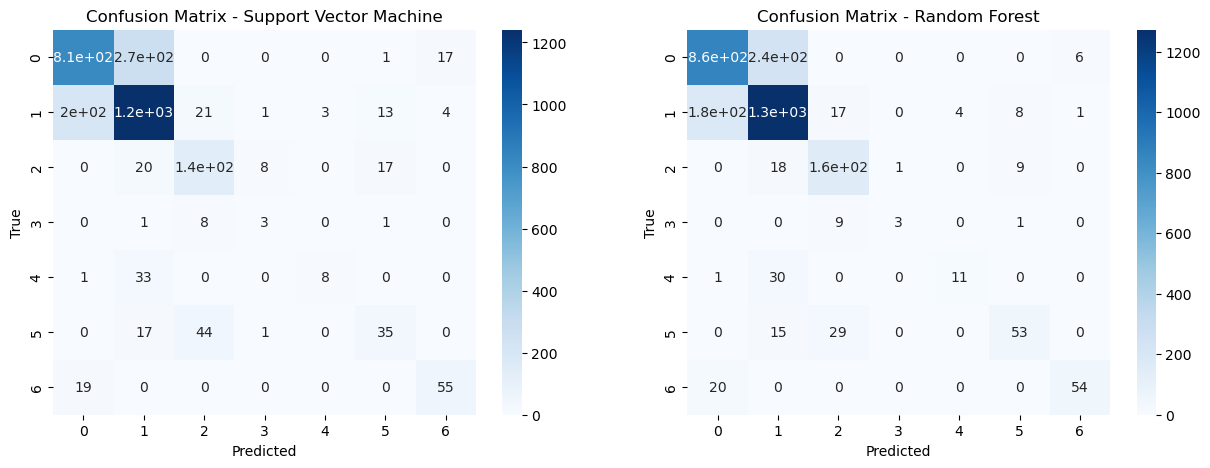

In [15]:
# generate confusion matrix for each model
svm_cm = confusion_matrix(y_test, svm_opt_pred)
rf_cm = confusion_matrix(y_test, rf_opt_pred)

# initialize subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# plot svm confusion matrix
sns.heatmap(svm_cm, annot=True, cmap='Blues', ax=axes[0])
axes[0].set_title("Confusion Matrix - Support Vector Machine")
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# plot rf confusion matrix
sns.heatmap(rf_cm, annot=True, cmap='Blues', ax=axes[1])
axes[1].set_title("Confusion Matrix - Random Forest")
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

### Step 5: Gather and display additional performance metrics
Now display the accuracy score and training time required for each model to so we can compare the models.

In [20]:
# print accuracy score for each model
print(f"The accuracy score for the support vector machine model = {accuracy_score(y_test, svm_opt_pred):.2f}")
print(f"The accuracy score for the random forest model = {accuracy_score(y_test, rf_opt_pred):.2f}")

# print the time required to run each model
print(f"Time required to run the support vector machine model = {end_time-start_time:.2f} seconds")
print(f"Time required to run the random forest model = {end_time_rf-start_time_rf:.2f} seconds")

The accuracy score for the support vector machine model = 0.77
The accuracy score for the random forest model = 0.80
Time required to run the support vector machine model = 102.19 seconds
Time required to run the random forest model = 445.75 seconds


### Step 6: Compare the models
Now that we have trained, optimized, and evaluated both SVM and RF models, we will compare them based on overall accuracy, training time, and types of errors made.

Based on these comparisons, which model is more suitable for this task?  


In accuracy, the random forest model performed better by a small margin, about 0.03 better. However, it took more than 4x the amount of time to run. It seems like the tradeoff of a little bit of increased accuracy for that much more run time is not worth it. Neither of the models, actually, performed incredibly well, with neither of their accuracies being above 0.80. Either way, it seems like the random forest model is more suitable if optimizing accuracy is your main goal, which it almost always is. 